# *O. polymorpha* as factory for small molecular weight biochemicals

The notebook explores the metabolic capacities of *O. polymorpha* to produce the small molecular weight biochemicals malate, acetone, and isoprene. For the analysis a modified genome scale model based on iUL909 [[Liebal et al., 2021](https://doi.org/10.1186/s12896-021-00675-w)] is used, in which reactions for acetone and isoprene production are added.

In [124]:
import sys # loading commands to control/navigate within the system architecture
# Loading pandas, a library for data manipulation
import os
import xlrd
import pandas as pd
import re
from datetime import date
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from itertools import product

# loading matplotlib, a library for visualization
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
%matplotlib inline
plt.rcParams['font.size'] = '14'
plt.rcParams['font.family'] = 'Calibri'

# loading cobrapy, a library dedicated to the analysis of genome scale metabolic models
from cobra.io import read_sbml_model, write_sbml_model
from cobra import Reaction, Metabolite
from iambcodes import countCinFormula, set_ObjGSMM, set_SubFlux, CreateTransReact

Today = date.today().strftime('%y%m%d')
SaveDir = os.path.join('..','data')
FigureType = 'png'

In [125]:

def set_SubiOpol(model, Sub, Flux):
    '''
    Setting the desired substrate in the model.
    
    Arguments:
    model: cobra model, iOpol909
    Sub: string/list, model metabolite ID
    Flux: float, desired substrate uptake rate
    
    Return:
    cobra model, updated with designed (co-) substrate uptake rates.
    '''
    model.reactions.get_by_id('Ex_glc_D').lower_bound = 0
    model.reactions.get_by_id('Ex_{}'.format(Sub[0])).lower_bound = -Flux
    return model

In [126]:
# generating cobra variable from SBML/xml file
# assuming the base path is in 'Simulation'
GSMM_File = os.path.join('..','model','iOpol23.xml') # iUL909.xml for the original model
model = read_sbml_model(GSMM_File)
model_copy = model.copy()

#### Optional: Adding reactions
Applicable only if the original model w/o additional reactions is used. 

To activate set the `run` variable to `True`.

In [127]:
run = False # True if you want to adapt the original model
if run:
    # more realistic fluxes by forcing TCA activity
    # model.reactions.get_by_id('MDH').bounds = 0,0
    # model.reactions.get_by_id('AKGMALtm').bounds = 0,0

    ID = 'IPSYN'
    if ID not in model.reactions:
        reaction = Reaction(ID)
        reaction.name = 'Isoprene synthase'
        reaction.lower_bound = 0.
        reaction.upper_bound = 1000.
    #     reaction.annotation = {'biocyc': 'FUCISOM-RXN', 'brenda': '5.3.1.25'}
        IP = Metabolite(
            'isoprene[c]',
            formula = 'C5H8',
            name = 'Isoprene',
            charge = 0,
            compartment = 'c',
        )
    #     IP.annotation = {'biocyc':'CPD-10329', 'chebi':'42548', 'chemspider':'388645', 'drugbank':'DB04473', 'inchi':'InChI=1S/C6H12O5/c1-2-3(7)4(8)5(9)6(10)11-2/h2-10H,1H3/t2-,3+,4+,5-,6+/m0/s1', 'kegg.compound':'C20835', 'pubchem':'439554'}    
        IPP = model.metabolites.get_by_id('ipdp[c]')
        DP = model.metabolites.get_by_id('ppi[c]')
        reaction.add_metabolites({IPP:-1., IP:1., DP:1.})
        model.add_reactions([reaction])

        print(model.reactions.get_by_id(ID).id)
        print(model.reactions.get_by_id(ID).reaction)
        print(model.reactions.get_by_id(ID).check_mass_balance())
    # Isoprene transport reaction
    TransIso = CreateTransReact(model.metabolites.get_by_id('isoprene[c]'),'[]')
    model.add_reactions([TransIso])
    model.add_boundary(model.metabolites.get_by_id('isoprene[e]'), type="exchange", lb=0)

    # Acetone production
    # Acetoacetyl-CoA hydrolase
    # https://biocyc.org/META/NEW-IMAGE?type=REACTION&object=ACETOACETYL-COA-HYDROLASE-RXN
    ID = 'AcAcCoAHYD'
    if ID not in model.reactions:
        reaction = Reaction(ID)
        reaction.name = 'Acetoacetyl-CoA Hydrolase'
        reaction.lower_bound = 0.
        reaction.upper_bound = 1000.
        reaction.annotation = {'biocyc': 'ACETOACETYL-COA-HYDROLASE-RXN', 'brenda': '3.1.2.11'}
        model.add_reactions([reaction])
        model.reactions.get_by_id(ID).build_reaction_from_string('aacoa[c] + h2o[c] --> acac[c] + coa[c] + h[c]')

        print(reaction.id)
        print(reaction.reaction)
        print(model.reactions.get_by_id(ID).check_mass_balance())

    # Acetoacetate decarboxylase
    # https://biocyc.org/META/NEW-IMAGE?type=REACTION&object=ACETOACETATE-DECARBOXYLASE-RXN
    ID = 'ACACDECARB'
    if ID not in model.reactions:
        reaction = Reaction(ID)
        reaction.name = 'Acetoacetate decarboxylase'
        reaction.lower_bound = 0.
        reaction.upper_bound = 1000.
        reaction.annotation = {'biocyc': 'ACETOACETATE-DECARBOXYLASE-RXN', 'brenda': '4.1.1.4'}
        ACONE = Metabolite(
            'acetone[c]',
            formula = 'C3H6O',
            name = 'Acetone',
            charge = 0,
            compartment = 'c',
        )
        ACONE.annotation = {'biocyc':'ACETONE', 'chebi':'15347', 'kegg.compound':'C00207', 'pubchem':'180'}    
        CO2 = model.metabolites.get_by_id('co2[c]')
        ACAC = model.metabolites.get_by_id('acac[c]')
        H = model.metabolites.get_by_id('h[c]')
        reaction.add_metabolites({ACAC:-1., H:-1., ACONE:1., CO2:1.})
        model.add_reactions([reaction])

        print(model.reactions.get_by_id(ID).id)
        print(model.reactions.get_by_id(ID).reaction)
        print(model.reactions.get_by_id(ID).check_mass_balance())

    # Acetone transport reaction
    TransAcetone = CreateTransReact(model.metabolites.get_by_id('acetone[c]'),'[]')
    model.add_reactions([TransAcetone])
    model.add_boundary(model.metabolites.get_by_id('acetone[e]'), type="exchange", lb=0)

    # write_sbml_model(model, "iOpol23.xml")
else:
    print('Using the adapted model iOpol23.xml')

Using the adapted model iOpol23.xml


#### Reaction definitions
The dictionary contains reaction identifiers for whom the fluxes are stored.

In [128]:
RctFluxName = {
               # 'Ex_meoh':1,
               'HEX1':6, 
               'G6PDH2':6, 
               'PYK':3,
               'PC':4,
               'FUM':4,
               'MDH':4, 
               'MDHm':4,
               'MDHp':4,
               'PDHa1':3,
               'CSm':6, 
               'ICDOXSUCm':6,
               'AKGDH1':6,
               'SUCOASm':4,
               'SUCD2_u6m':4,
               'AKGMALtm':5, 
               'ICL':6, 
            #    'SUCDH_q6_m':4, 
            #    'MALSm':4, 
               # 'Ex_co2':1,
               # 'DM_mal_L[e]':4,
               }

[print(model.reactions.get_by_id(Rct)) for Rct in RctFluxName.keys()];

HEX1: atp[c] + glc_D[c] --> adp[c] + g6p[c] + h[c]
G6PDH2: g6p[c] + nadp[c] --> 6pgl[c] + h[c] + nadph[c]
PYK: adp[c] + h[c] + pep[c] --> atp[c] + pyr[c]
PC: atp[c] + hco3[c] + pyr[c] --> adp[c] + h[c] + oaa[c] + pi[c]
FUM: fum[c] + h2o[c] <=> mal_L[c]
MDH: mal_L[c] + nad[c] <=> h[c] + nadh[c] + oaa[c]
MDHm: mal_L[m] + nad[m] <=> h[m] + nadh[m] + oaa[m]
MDHp: mal_L[x] + nad[x] <=> h[x] + nadh[x] + oaa[x]
PDHa1: h[m] + pyr[m] + thmpp[m] --> 2_Hydroxyethyl_ThPP[m] + co2[m]
CSm: accoa[m] + h2o[m] + oaa[m] --> cit[m] + coa[m] + h[m]
ICDOXSUCm: icit[m] + nad[m] --> h[m] + nadh[m] + oxasucc[m]
AKGDH1: akg[m] + 5.0 h[m] + thmpp[m] --> 3_Carboxy_1_hydroxypropyl_ThPP[m] + co2[m]
SUCOASm: atp[m] + coa[m] + succ[m] <=> adp[m] + pi[m] + succoa[m]
SUCD2_u6m: q6[m] + succ[m] <=> fum[m] + q6h2[m]
AKGMALtm: akg[m] + mal_L[c] --> akg[c] + mal_L[m]
ICL: icit[c] --> glx[c] + succ[c]


#### Finding metabolites in model

In [129]:
# Searching for metabolite IDs
# CheckMetName = 'Acetone'
# [print('{}:\t{}:\t{}:\t{}\n'.format(MetID.name, MetID.id, MetID.formula, MetID.annotation)) for MetID in model.metabolites.query(CheckMetName, 'name')];

CheckMetID = 'mal_L[c]'
[print(f'{myRct.id}: {myRct.reaction}') for myRct in model.metabolites.get_by_id(CheckMetID).reactions];

ME1: mal_L[c] + nad[c] --> co2[c] + nadh[c] + pyr[c]
CITtap: cit[x] + mal_L[c] <=> cit[c] + mal_L[x]
MALSUCCtm: mal_L[c] + succ[m] <=> mal_L[m] + succ[c]
FUM: fum[c] + h2o[c] <=> mal_L[c]
MALS: accoa[c] + glx[c] + h2o[c] --> coa[c] + h[c] + mal_L[c]
ME2: mal_L[c] + nadp[c] --> co2[c] + nadph[c] + pyr[c]
AKGMALtp: akg[c] + mal_L[x] <=> akg[x] + mal_L[c]
MALtm: mal_L[c] + pi[m] --> mal_L[m] + pi[c]
MDH: mal_L[c] + nad[c] <=> h[c] + nadh[c] + oaa[c]
CITtam: cit[c] + mal_L[m] <=> cit[m] + mal_L[c]
MALt2r: h[e] + mal_L[e] <=> h[c] + mal_L[c]
MALOAAtp: mal_L[x] + oaa[c] <=> mal_L[c] + oaa[x]
AKGMALtm: akg[m] + mal_L[c] --> akg[c] + mal_L[m]
AKGMAL: akg[c] + mal_L[e] <=> akg[e] + mal_L[c]


### Production envelope Growth-rate versus Yield
The following cell determines the production envelope of the production of malate, acetate, and isoprene with different growth rates.

In [130]:
# required minimum growth rate
bio = np.linspace(.001,.12,5)
Substrate = 'meoh'
flux=10
Product = ['mal_L[e]','acetone[e]','isoprene[e]']
PCol = {'mal_L[e]':'m', 'acetone[e]':'b', 'isoprene[e]':'g'}
PMark = {'mal_L[e]':'x', 'acetone[e]':'o', 'isoprene[e]':'d'}
YieldProd = dict()

for myProd in Product:
    Cnum = countCinFormula(model.metabolites.get_by_id(myProd).formula)
    Yield = list()
    for bioi in bio:
        with model as md:
            md.reactions.get_by_id('BIOMASS').lower_bound = bioi
            md = set_ObjGSMM(md, myProd)
            md = set_SubFlux(md, [Substrate], 'Ex_glc_D', flux)
            sol = md.optimize()
            Yield.append(sol.fluxes['DM_{}'.format(myProd)]*Cnum/flux)
    YieldProd[myProd] = {'Yield':Yield, 'growth':list(bio), 'color':PCol[myProd], 'marker': PMark[myProd]}


Figure saved as ../data/230725_ProdYields-VS-Growth.png


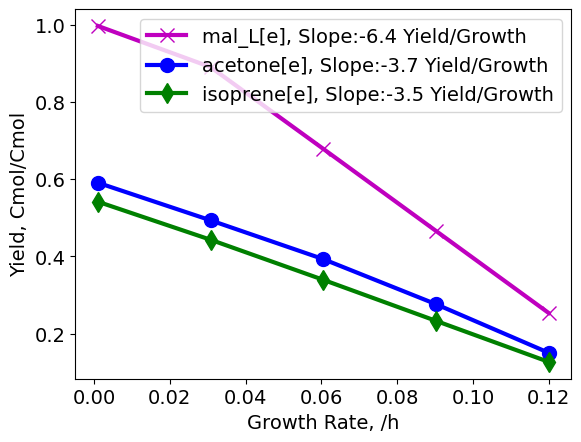

In [131]:
FigureName = 'ProdYields-VS-Growth'
for Target in YieldProd.keys():
    m,n = np.polyfit(YieldProd[Target]['growth'], YieldProd[Target]['Yield'], 1)
    plt.plot(YieldProd[Target]['growth'], YieldProd[Target]['Yield'], 
                c = PCol[Target], 
                marker = PMark[Target], markersize = 10, linewidth = 3,
                label = f'{Target}, Slope:{round(m,1)} Yield/Growth')
plt.xlabel('Growth Rate, /h')
plt.ylabel('Yield, Cmol/Cmol')
plt.legend()
PlotName = os.path.join(SaveDir, f'{Today}_{FigureName}.{FigureType}')
plt.savefig(PlotName, dpi=300, bbox_inches='tight')
print(f'Figure saved as {PlotName}')
# plt.title('PYC Active') #+AKG/Mal mTran
plt.show()

## Malate Yield for Different Pathways

Scenarios analysed:
- Blocked TCA: deactivation of pyruvate dehydrogenase (PDH) and mitochondrial acetolactate synthase (ACLSm)
- Forced TCA: minimum reaction flux through alpha-ketoglutarate dehydrogenase (AKGDam)
- Forced standard Glyoxylate shunt: minimum reaction flux through isocitrate lyase (ICL)
- Forced impaired Glyoxylate shunt: minimum reaction flux through isocitrate lyase (ICL), deactivated malate dehydrogenase (MDHm)

### General simulation setup
- Methanol is used as sole substrate with uptake rate of 10 mmol/gDW/h.
- The objective function is set to malate.
- All results are stored in a csv-file with the name `[Date]_MalPathFlux.csv`

In [10]:
model_mal = model.copy()

# setting dictionary to store all flux results
FluxAll = dict()

def Model_Unconstrained(model, target):
    '''
    Setting the model to be unconstrained. With target as the desired product, the model will be optimized for production.
    '''
    # optimizing for production
    set_ObjGSMM(model, target)
    set_SubFlux(model, ['meoh'], 'Ex_glc_D', 10)
    # setting cytoplasmic malate dehydrogenase as reversible
    model.reactions.get_by_id('MDH').bounds = -1000,1000
    return model


def Model_BlockedTCA(model, target):
    '''
    Setting the TCA cycle to be blocked. With target as the desired product, the model will be optimized for production.
    '''
    # optimizing for production
    set_ObjGSMM(model, target)
    set_SubFlux(model, ['meoh'], 'Ex_glc_D', 10)
    # setting cytoplasmic malate dehydrogenase as reversible
    model.reactions.get_by_id('MDH').bounds = -1000,1000

    model.reactions.get_by_id('PDHa1').upper_bound = 0
    model.reactions.get_by_id('PDHcm').upper_bound = 0
    model.reactions.get_by_id('ACLSm').upper_bound = 0
    model.reactions.get_by_id('AKGDH1').upper_bound = 0
    model.reactions.get_by_id('AKGDH2').upper_bound = 0
    model.reactions.get_by_id('CITtam').upper_bound = 0
    model.reactions.get_by_id('CITtap').upper_bound = 0
    model.reactions.get_by_id('CSp').upper_bound = 0
    model.reactions.get_by_id('CSm').upper_bound = 0
    
    return model

def Model_ForceTCA(model, target):
    '''
    Setting the TCA cycle to be active. With target as the desired product, the model will be optimized for production.
    '''
    # optimizing for production
    set_ObjGSMM(model, target)
    set_SubFlux(model, ['meoh'], 'Ex_glc_D', 10)
    # setting cytoplasmic malate dehydrogenase as reversible
    model.reactions.get_by_id('MDH').bounds = -1000,1000
    model.reactions.get_by_id('AKGDam').lower_bound = 7.8
    return model

def Model_ForceStdGlx(model, target):
    '''
    Setting the Glx cycle to be active. With target as the desired product, the model will be optimized for production.
    '''
    # optimizing for production
    set_ObjGSMM(model, target)
    set_SubFlux(model, ['meoh'], 'Ex_glc_D', 10)
    # setting cytoplasmic malate dehydrogenase as reversible
    model.reactions.get_by_id('MDH').bounds = -1000,1000

    model.reactions.get_by_id('ICL').lower_bound = 10
    return model

def Model_ForceImpGlx(model, target):
    '''
    Setting the Glx cycle to be active but with mutations in MDHm. With target as the desired product, the model will be optimized for production.
    '''
    # optimizing for production
    set_ObjGSMM(model, target)
    set_SubFlux(model, ['meoh'], 'Ex_glc_D', 10)
    # setting cytoplasmic malate dehydrogenase as reversible
    model.reactions.get_by_id('MDH').bounds = -1000,1000
    model.reactions.get_by_id('ICL').lower_bound = 10
    model.reactions.get_by_id('MDHm').bounds = -10, 2.85
    return model


### Unconstrained optimal malate flux

In [11]:
with model_mal as md:
    FluxScenario = dict()
    for target in Product:
        # optimizing for production
        md = Model_Unconstrained(md, target)
        sol = md.optimize()
        print(sol.fluxes[f'DM_{target}'])
        # yield of malate from methanol
        print(-sol.fluxes[f'DM_{target}']*4/sol.fluxes['Ex_meoh'])
        # print exchange fluxes
        print(md.summary())
        FluxScenario[target] = {md.reactions.get_by_id(Rct).id: round(sol[Rct],2) for Rct in sol[np.abs(sol.fluxes)>1e-2].keys()}
    FluxAll['UnconstrainedRef'] = FluxScenario

print('')
[print(f'{model_mal.reactions.get_by_id(Rct).id} \t {model_mal.reactions.get_by_id(Rct).reaction} \t {round(sol[Rct],2)}') for Rct in RctFluxName.keys()];

2.4999999999999933
0.9999999999999973
Objective
1.0 DM_mal_L[e] = 2.4999999999999933

Uptake
------
Metabolite Reaction Flux  C-Number  C-Flux
   meoh[e]  Ex_meoh   10         1 100.00%
     o2[e]    Ex_o2  7.5         0   0.00%

Secretion
---------
Metabolite    Reaction  Flux  C-Number  C-Flux
  mal_L[e] DM_mal_L[e]  -2.5         4 100.00%
      h[e]        Ex_h    -5         0   0.00%
    h2o[e]      Ex_h2o -12.5         0   0.00%

1.960303030303025
0.78412121212121
Objective
1.0 DM_acetone[e] = 1.960303030303025

Uptake
------
Metabolite Reaction  Flux  C-Number  C-Flux
   meoh[e]  Ex_meoh    10         1 100.00%
     o2[e]    Ex_o2 7.159         0   0.00%

Secretion
---------
Metabolite      Reaction   Flux  C-Number C-Flux
acetone[e] DM_acetone[e]  -1.96         3 58.81%
    co2[e]        Ex_co2 -4.119         1 41.19%
    h2o[e]        Ex_h2o -14.12         0  0.00%

1.0724999999999956
0.4289999999999982
Objective
1.0 DM_isoprene[e] = 1.0724999999999956

Uptake
------
Metabolite

### Blocked TCA scenario

In [12]:

with model_mal as md:
    FluxScenario = dict()
    for target in Product:
        # optimizing for production
        md = Model_BlockedTCA(md, target)

        sol = md.optimize()
        print(sol.fluxes[f'DM_{target}'])
        # yield of malate from methanol
        print(-sol.fluxes[f'DM_{target}']*4/sol.fluxes['Ex_meoh'])
        # print exchange fluxes
        print(md.summary())
        FluxScenario[target] = {md.reactions.get_by_id(Rct).id: round(sol[Rct],2) for Rct in sol[np.abs(sol.fluxes)>1e-2].keys()}
    FluxAll['BlockedTCA'] = FluxScenario

2.4718181818181773
0.9887272727272709
Objective
1.0 DM_mal_L[e] = 2.4718181818181773

Uptake
------
Metabolite Reaction  Flux  C-Number  C-Flux
   meoh[e]  Ex_meoh    10         1 100.00%
     o2[e]    Ex_o2 7.585         0   0.00%

Secretion
---------
Metabolite    Reaction    Flux  C-Number C-Flux
  mal_L[e] DM_mal_L[e]  -2.472         4 98.87%
    co2[e]      Ex_co2 -0.1127         1  1.13%
      h[e]        Ex_h  -4.944         0  0.00%
    h2o[e]      Ex_h2o  -12.58         0  0.00%

1.7709523809523904
0.7083809523809561
Objective
1.0 DM_acetone[e] = 1.7709523809523904

Uptake
------
Metabolite Reaction  Flux  C-Number  C-Flux
   meoh[e]  Ex_meoh    10         1 100.00%
     o2[e]    Ex_o2 7.916         0   0.00%

Secretion
---------
Metabolite      Reaction   Flux  C-Number C-Flux
acetone[e] DM_acetone[e] -1.771         3 53.13%
    co2[e]        Ex_co2 -4.687         1 46.87%
    h2o[e]        Ex_h2o -14.69         0  0.00%

0.9063333333333259
0.3625333333333304
Objective
1.0 DM

### Forced TCA scenario

In [13]:
with model_mal as md:
    FluxScenario = dict()
    for target in Product:
        # optimizing for production
        md = Model_ForceTCA(md, target)

        sol = md.optimize()
        print(sol.fluxes[f'DM_{target}'])
        # yield of malate from methanol
        print(-sol.fluxes[f'DM_{target}']*4/sol.fluxes['Ex_meoh'])
        # print exchange fluxes
        print(md.summary())
        FluxScenario[target] = {md.reactions.get_by_id(Rct).id: round(sol[Rct],2) for Rct in sol[np.abs(sol.fluxes)>1e-2].keys()}
    FluxAll['ForcedTCA'] = FluxScenario

0.010545454545435344
0.0042181818181741375
Objective
1.0 DM_mal_L[e] = 0.010545454545437812

Uptake
------
Metabolite Reaction  Flux  C-Number  C-Flux
   meoh[e]  Ex_meoh    10         1 100.00%
     o2[e]    Ex_o2 14.97         0   0.00%

Secretion
---------
Metabolite    Reaction     Flux  C-Number C-Flux
  mal_L[e] DM_mal_L[e] -0.01055         4  0.42%
    co2[e]      Ex_co2   -9.958         1 99.58%
      h[e]        Ex_h -0.02109         0  0.00%
    h2o[e]      Ex_h2o   -19.97         0  0.00%

0.007073170731648471
0.0028292682926593883
Objective
1.0 DM_acetone[e] = 0.007073170731649599

Uptake
------
Metabolite Reaction  Flux  C-Number  C-Flux
   meoh[e]  Ex_meoh    10         1 100.00%
     o2[e]    Ex_o2 14.97         0   0.00%

Secretion
---------
Metabolite      Reaction      Flux  C-Number C-Flux
acetone[e] DM_acetone[e] -0.007073         3  0.21%
    co2[e]        Ex_co2    -9.979         1 99.79%
    h2o[e]        Ex_h2o    -19.98         0  0.00%

0.0038926174496429302
0

### Forced standard Glyoxylate shunt

In [14]:
with model_mal as md:
    FluxScenario = dict()
    for target in Product:
        # optimizing for production
        md = Model_ForceStdGlx(md, target)
        sol = md.optimize()
        print(sol.fluxes[f'DM_{target}'])
        # yield of malate from methanol
        print(-sol.fluxes[f'DM_{target}']*4/sol.fluxes['Ex_meoh'])
        # print exchange fluxes
        print(md.summary())
        FluxScenario[target] = {md.reactions.get_by_id(Rct).id: round(sol[Rct],2) for Rct in sol[np.abs(sol.fluxes)>1e-2].keys()}
    FluxAll['ForcedStdGlx'] = FluxScenario

0.2396666666666701
0.09586666666666804
Objective
1.0 DM_mal_L[e] = 0.2396666666666701

Uptake
------
Metabolite Reaction  Flux  C-Number  C-Flux
   meoh[e]  Ex_meoh    10         1 100.00%
     o2[e]    Ex_o2 14.28         0   0.00%

Secretion
---------
Metabolite    Reaction    Flux  C-Number C-Flux
  mal_L[e] DM_mal_L[e] -0.2397         4  9.59%
    co2[e]      Ex_co2  -9.041         1 90.41%
      h[e]        Ex_h -0.4793         0  0.00%
    h2o[e]      Ex_h2o  -19.28         0  0.00%

0.15630434782610814
0.06252173913044326
Objective
1.0 DM_acetone[e] = 0.15630434782610814

Uptake
------
Metabolite Reaction  Flux  C-Number  C-Flux
   meoh[e]  Ex_meoh    10         1 100.00%
     o2[e]    Ex_o2 14.37         0   0.00%

Secretion
---------
Metabolite      Reaction    Flux  C-Number C-Flux
acetone[e] DM_acetone[e] -0.1563         3  4.69%
    co2[e]        Ex_co2  -9.531         1 95.31%
    h2o[e]        Ex_h2o  -19.53         0  0.00%

0.08768292682926294
0.035073170731705176
Objec

### Forced impaired Glyoxylate shunt

In [15]:
with model_mal as md:
    FluxScenario = dict()
    for target in Product:
        # optimizing for production
        md = Model_ForceImpGlx(md, target)
        sol = md.optimize()
        print(sol.fluxes[f'DM_{target}'])
        # yield of malate from methanol
        print(-sol.fluxes[f'DM_{target}']*4/sol.fluxes['Ex_meoh'])
        # print exchange fluxes
        print(md.summary())
        FluxScenario[target] = {md.reactions.get_by_id(Rct).id: round(sol[Rct],2) for Rct in sol[np.abs(sol.fluxes)>1e-2].keys()}
    FluxAll['ForcedImpGlx'] = FluxScenario
# print('')
# [print(f'{model_mal.reactions.get_by_id(Rct).id} \t {model_mal.reactions.get_by_id(Rct).reaction} \t {round(sol[Rct],2)}') for Rct in RctFluxName.keys()];

0.0014285714286157397
0.0005714285714462959
Objective
1.0 DM_mal_L[e] = 0.0014285714286119387

Uptake
------
Metabolite Reaction Flux  C-Number  C-Flux
   meoh[e]  Ex_meoh   10         1 100.00%
     o2[e]    Ex_o2   15         0   0.00%

Secretion
---------
Metabolite    Reaction      Flux  C-Number C-Flux
  mal_L[e] DM_mal_L[e] -0.001429         4  0.06%
    co2[e]      Ex_co2    -9.994         1 99.94%
      h[e]        Ex_h -0.002857         0  0.00%
    h2o[e]      Ex_h2o       -20         0  0.00%

0.0009356725146208696
0.00037426900584834784
Objective
1.0 DM_acetone[e] = 0.0009356725146208696

Uptake
------
Metabolite Reaction Flux  C-Number  C-Flux
   meoh[e]  Ex_meoh   10         1 100.00%
     o2[e]    Ex_o2   15         0   0.00%

Secretion
---------
Metabolite      Reaction       Flux  C-Number C-Flux
acetone[e] DM_acetone[e] -0.0009357         3  0.03%
    co2[e]        Ex_co2     -9.997         1 99.97%
    h2o[e]        Ex_h2o        -20         0  0.00%

0.0005263157894

### File export of data

In [16]:
# export fluxes from transposed myResults to xlsx file with multiple sheets
File = os.path.join(SaveDir, f'{Today}_ScenarioPathFlux.xlsx')
myResults = pd.DataFrame(FluxAll).transpose()
with pd.ExcelWriter(File) as writer:
    for target in list(myResults.columns):
        print(target)
        # print(myResults.to_dict()[target])
        pd.DataFrame(myResults[target].to_dict()).to_excel(writer, sheet_name=target[:-3])
        print('') 
        # print file location
print(f'Flux file saved in {File}')
        
# # Alternative storage of each flux scenario in separate files
# FlxFile = f'{Today}_FluxMalGlxACyc.txt'
# # remove file if exists
# if os.path.exists(FlxFile):
#     os.remove(FlxFile)
# with open(FlxFile, 'a') as f:
#     [print(f'{model_mal.reactions.get_by_id(Rct).id} \t {model_mal.reactions.get_by_id(Rct).reaction} \t {round(sol[Rct],2)}', file=f) for Rct in sol[np.abs(sol.fluxes)>1e-2].keys()];
# # print file location
# print(f'Flux file saved in {FlxFile}')

mal_L[e]

acetone[e]

isoprene[e]

Flux file saved in ../data/230725_ScenarioPathFlux.xlsx


### PCA of scenario fluxes
A PCA of the fluxes of the scenarios shows how different the solutions are.

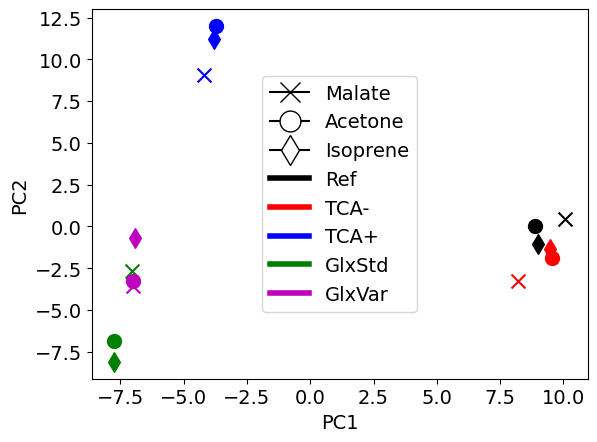

In [109]:
IndxList = list()
for target in myResults.columns:
    IndxList.append(pd.DataFrame(myResults[target].to_dict()).index)
# find intersection of all indices in IndxList
Indx = list(set.intersection(*map(set, IndxList)))


# Constructing a PCA plot of the fluxes in the dataframe myResults for all components but only with the index values in Indx
myMark = {'mal_L[e]':'x', 'acetone[e]':'o', 'isoprene[e]':'d'}
# Dictionary with labels for the different scenarios
myLabel = {'UnconstrainedRef':'Ref', 'BlockedTCA':'TCA-', 'ForcedTCA':'TCA+', 'ForcedStdGlx':'GlxStd', 'ForcedImpGlx':'GlxVar'}
myLabelColor = {'Ref':'k', 'TCA-':'r', 'TCA+':'b', 'GlxStd':'g', 'GlxVar':'m'}
AllDatSeq = list(product(myMark.keys(), myLabel.values()))
PlotLabel = [[myMark[element[0]],myLabelColor[element[1]]] for element in AllDatSeq]
PrintLabel = [f'{element[0]}-{element[1]}' for element in AllDatSeq]

x = list()
for target in list(myResults.columns):
    # Replacing NaN values with 0
    myDat = pd.DataFrame(myResults[target].to_dict()).fillna(0).loc[Indx]

    # Standardizing the features
    x.append(StandardScaler().fit_transform(myDat.T))
x = np.array(x).reshape(-1, 135)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'], index = PrintLabel)
# adding columns for target marker type and pathway color
principalDf['Target'] = [mylist[0] for mylist in PlotLabel]
principalDf['Path'] = [mylist[1] for mylist in PlotLabel]

# Plotting the PCA
# plt.figure(figsize=(10,10))
plt.xlabel('PC1')
plt.ylabel('PC2')
for idx, row in principalDf.iterrows():
    plt.scatter(row['PC1'], row['PC2'], s=100, marker=row['Target'], c=row['Path'], label=idx)

# adding manual legend for target marker and pathway color
# https://matplotlib.org/stable/gallery/text_labels_and_annotations/custom_legends.html
legend_elements = [Line2D([0], [0], marker='x', color='k', label='Malate', markerfacecolor='w', markersize=15),
                   Line2D([0], [0], marker='o', color='k', label='Acetone', markerfacecolor='w', markersize=15),
                   Line2D([0], [0], marker='d', color='k', label='Isoprene', markerfacecolor='w', markersize=15),
                   Line2D([0], [0], color='k', lw=4, label='Ref'),
                   Line2D([0], [0], color='r', lw=4, label='TCA-'),
                   Line2D([0], [0], color='b', lw=4, label='TCA+'),
                   Line2D([0], [0], color='g', lw=4, label='GlxStd'),
                   Line2D([0], [0], color='m', lw=4, label='GlxVar')]
# plt.legend(handles = legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.legend(handles = legend_elements, loc='center')


# saving figure
FigureName = 'PCA-Flux-All'
PlotName = os.path.join(SaveDir, f'{Today}_{FigureName}.{FigureType}')
plt.savefig(PlotName, dpi=300, bbox_inches='tight')
plt.show()

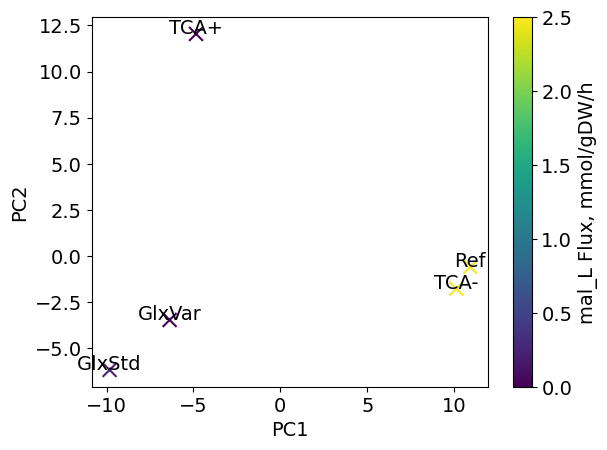

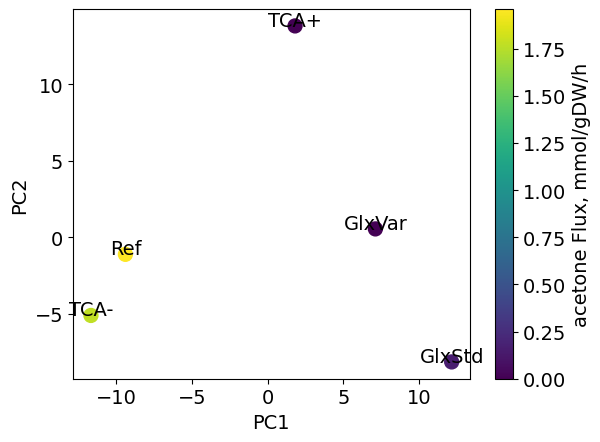

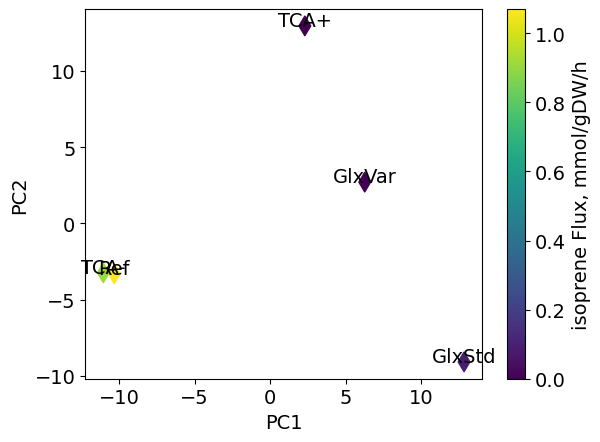

In [17]:
# Constructing a PCA plot of the fluxes in the dataframe myResults as a contourf plot with the flux/row of 'DM_mal_L[e]' as the color
myMark = {'mal_L[e]':'x', 'acetone[e]':'o', 'isoprene[e]':'d'}
# Dictionary with labels for the different scenarios
myLabel = {'UnconstrainedRef':'Ref', 'BlockedTCA':'TCA-', 'ForcedTCA':'TCA+', 'ForcedStdGlx':'GlxStd', 'ForcedImpGlx':'GlxVar'}
for target in list(myResults.columns):
    # Replacing NaN values with 0
    myDat = pd.DataFrame(myResults[target].to_dict()).fillna(0)

    # Standardizing the features
    x = StandardScaler().fit_transform(myDat.T)

    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'], index = myDat.columns)

    # Plotting the PCA
    # plt.figure(figsize=(10,10))
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.scatter(principalDf['PC1'], principalDf['PC2'], s=100, c=myDat.loc[f'DM_{target}'], cmap='viridis', marker=myMark[target])
    for i, txt in enumerate(principalDf.index):
        plt.annotate(myLabel[txt], (principalDf['PC1'][i], principalDf['PC2'][i]), ha='center')

    # adding colorbar and text
    cbar = plt.colorbar()
    cbar.set_label(f'{target[:-3]} Flux, mmol/gDW/h')

    # saving figure
    FigureName = f'PCA-Flux-{target[:-3]}'
    PlotName = os.path.join(SaveDir, f'{Today}_{FigureName}.{FigureType}')
    plt.savefig(PlotName, dpi=300, bbox_inches='tight')
    plt.show()

## Energetic demand of Mal production

The scenarios of `ForcedTCA` and `ForcedImpairedGLX` assume minimum fluxes through TCA and glyoxylate shunt reactions which are tailored to the methanol uptake rate and thus are too inflexible to allow optimization of ATP maintenance along with a minimun target production rate.

In [239]:
# dictionary with the target theoretical yields for each product
YieldFrac = 1/50
YieldTh = {'mal_L[e]':10/4*YieldFrac, 'acetone[e]':10/2*YieldFrac, 'isoprene[e]':10/5*YieldFrac}
YieldTh

exp4all = dict()
Ref = dict()
BTCA = dict()
FTCA = dict()
FSGlx = dict()
FIGlx = dict()
for target in Product:
    # Reference unconstrained scenario
    with model as md :
        md = Model_Unconstrained(md, target)
        md.objective = 'ATPM'
        md.reactions.get_by_id(f'DM_{target}').bounds = YieldTh[target],100
        mySol = md.optimize()
        # print(md.summary())
        Ref[target] = mySol

    # Blocked TCA scenario
    with model as md :
        md = Model_BlockedTCA(md, target)
        md.objective = 'ATPM'
        md.reactions.get_by_id(f'DM_{target}').bounds = YieldTh[target],100
        mySol = md.optimize()
        # print(md.summary())
        BTCA[target] = mySol

    # Forced TCA scenario
    with model as md :
        md = Model_ForceTCA(md, target)
        md.objective = 'ATPM'
        md.reactions.get_by_id(f'DM_{target}').bounds = YieldTh[target],100
        mySol = md.optimize()
        # print(md.summary())
        FTCA[target] = mySol

    # Forced StdGlx scenario
    with model as md :
        md = Model_ForceStdGlx(md, target)
        md.objective = 'ATPM'
        md.reactions.get_by_id(f'DM_{target}').bounds = YieldTh[target],100
        mySol = md.optimize()
        # print(md.summary())
        FSGlx[target] = mySol

    # Forced ImpGlx scenario
    with model as md :
        md = Model_ForceImpGlx(md, target)
        md.objective = 'ATPM'
        md.reactions.get_by_id(f'DM_{target}').bounds = YieldTh[target],100
        mySol = md.optimize()
        # print(md.summary())
        FIGlx[target] = mySol

    exp4all = dict(zip(['Ref','BTCA','FTCA','FSGlx','FIGlx'],[Ref,BTCA,FTCA,FSGlx,FIGlx]))

    # FigureName = f'PathFluxCond-VS-MaxATP_{target}'

    # ATPmax = [exp4all[Condition].objective_value for Condition in exp4all.keys()]
    # plt.bar(exp4all.keys(), ATPmax)
    # plt.ylabel('Maximum ATP Flux, mmol/gDW/h')
    # plt.title(target)
    # # plt.savefig(f'{Today}_{FigureName}.{FigureType}')
    # plt.show()


In [240]:
exp4all

{'Ref': {'mal_L[e]': <Solution 44.225 at 0x7f3b05b7bb80>,
  'acetone[e]': <Solution 42.975 at 0x7f3b05df2490>,
  'isoprene[e]': <Solution 43.460 at 0x7f3b05dc5ca0>},
 'BTCA': {'mal_L[e]': <Solution 29.450 at 0x7f3b05b6e1c0>,
  'acetone[e]': <Solution 28.500 at 0x7f3b05df2fd0>,
  'isoprene[e]': <Solution 28.800 at 0x7f3b0c65a7f0>},
 'FTCA': {'mal_L[e]': <Solution infeasible at 0x7f3b0b05f580>,
  'acetone[e]': <Solution infeasible at 0x7f3b05ac2b50>,
  'isoprene[e]': <Solution infeasible at 0x7f3b0c67a310>},
 'FSGlx': {'mal_L[e]': <Solution 8.500 at 0x7f3b0bfe27c0>,
  'acetone[e]': <Solution 5.400 at 0x7f3b05dcc6a0>,
  'isoprene[e]': <Solution 6.720 at 0x7f3b0c67adf0>},
 'FIGlx': {'mal_L[e]': <Solution infeasible at 0x7f3b05b68940>,
  'acetone[e]': <Solution infeasible at 0x7f3b05dc51c0>,
  'isoprene[e]': <Solution infeasible at 0x7f3b0c677940>}}

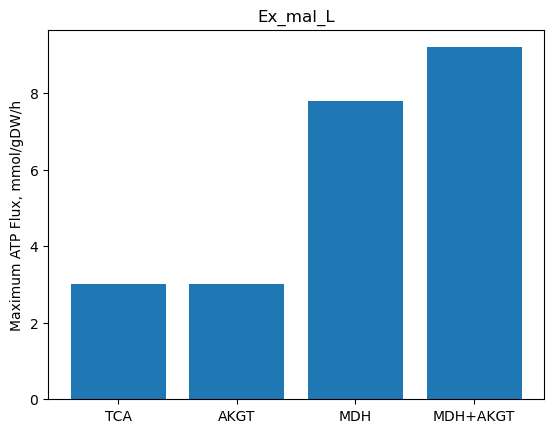

In [ ]:
model.reactions.get_by_id('MDH').bounds = 0,0
model.reactions.get_by_id('AKGMALtm').bounds = 0,0

GlcEx = 'Ex_glc_D'
Substrate = 'meoh'
flux = 10
Target = 'Ex_mal_L' # Ex_mal_L
TarRate = 2.4
exp4all = dict()
with model as md :
    md.objective = 'ATPM'
    md = set_SubFlux(md, [Substrate], GlcEx, flux)
    md.reactions.get_by_id(Target).bounds = TarRate,100
    mySol = md.optimize()
    # print(md.summary())
    exp4all['TCA'] = mySol

with model as md :
    md.objective = 'ATPM'
    md = set_SubFlux(md, [Substrate], GlcEx, flux)
    md.reactions.get_by_id(Target).bounds = TarRate,100
    md.reactions.get_by_id('AKGMALtm').bounds = -1000,1000
    mySol = md.optimize()
    # print(md.summary())
    exp4all['AKGT'] = mySol

with model as md :
    md.objective = 'ATPM'
    md = set_SubFlux(md, [Substrate], GlcEx, flux)
    md.reactions.get_by_id(Target).bounds = TarRate,100
    md.reactions.get_by_id('MDH').bounds = -1000,1000
    mySol = md.optimize()
    # print(md.summary())
    exp4all['MDH'] = mySol
    
with model as md :
    md.objective = 'ATPM'
    md = set_SubFlux(md, [Substrate], GlcEx, flux)
    md.reactions.get_by_id(Target).bounds = TarRate,100
    md.reactions.get_by_id('MDH').bounds = -1000,1000
    md.reactions.get_by_id('AKGMALtm').bounds = -1000,1000
    mySol = md.optimize()
    # print(md.summary())
    exp4all['MDH+AKGT'] = mySol

FigureName = f'PathFluxCond-VS-MaxATP_{Target}'

ATPmax = [exp4all[Condition].objective_value for Condition in exp4all.keys()]
plt.bar(exp4all.keys(), ATPmax)
plt.ylabel('Maximum ATP Flux, mmol/gDW/h')
plt.title(Target)
# plt.savefig(f'{Today}_{FigureName}.{FigureType}')
plt.show()


## Energetic demand of Acetone production

/home/ulf/anaconda3/envs/iambjudas/lib/python3.9/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


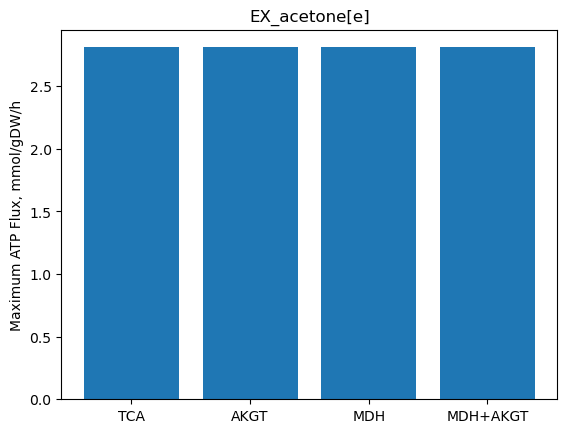

In [21]:
model.reactions.get_by_id('MDH').bounds = 0,0
model.reactions.get_by_id('AKGMALtm').bounds = 0,0

GlcEx = 'Ex_glc_D'
Substrate = 'meoh'
flux = 10
Target = 'EX_acetone[e]' # Ex_mal_L
TarRate = 2.4
exp4all = dict()
with model as md :
    md.objective = 'ATPM'
    md = set_SubFlux(md, [Substrate], GlcEx, flux)
    md.reactions.get_by_id(Target).bounds = TarRate,100
    mySol = md.optimize()
    # print(md.summary())
    exp4all['TCA'] = mySol

with model as md :
    md.objective = 'ATPM'
    md = set_SubFlux(md, [Substrate], GlcEx, flux)
    md.reactions.get_by_id(Target).bounds = TarRate,100
    md.reactions.get_by_id('AKGMALtm').bounds = -1000,1000
    mySol = md.optimize()
    # print(md.summary())
    exp4all['AKGT'] = mySol

with model as md :
    md.objective = 'ATPM'
    md = set_SubFlux(md, [Substrate], GlcEx, flux)
    md.reactions.get_by_id(Target).bounds = TarRate,100
    md.reactions.get_by_id('MDH').bounds = -1000,1000
    mySol = md.optimize()
    # print(md.summary())
    exp4all['MDH'] = mySol
    
with model as md :
    md.objective = 'ATPM'
    md = set_SubFlux(md, [Substrate], GlcEx, flux)
    md.reactions.get_by_id(Target).bounds = TarRate,100
    md.reactions.get_by_id('MDH').bounds = -1000,1000
    md.reactions.get_by_id('AKGMALtm').bounds = -1000,1000
    mySol = md.optimize()
    # print(md.summary())
    exp4all['MDH+AKGT'] = mySol

FigureName = f'PathFluxCond-VS-MaxATP_{Target}'

ATPmax = [exp4all[Condition].objective_value for Condition in exp4all.keys()]
plt.bar(exp4all.keys(), ATPmax)
plt.ylabel('Maximum ATP Flux, mmol/gDW/h')
plt.title(Target)
# plt.savefig(f'{Today}_{FigureName}.{FigureType}')
plt.show()


## Energetic demand of Isopren production

/home/ulf/anaconda3/envs/iambjudas/lib/python3.9/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


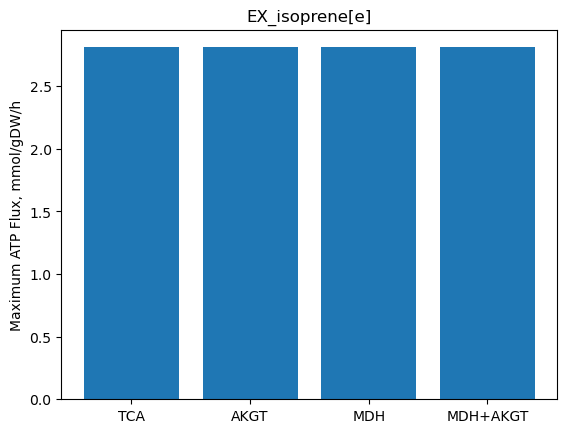

In [22]:
model.reactions.get_by_id('MDH').bounds = 0,0
model.reactions.get_by_id('AKGMALtm').bounds = 0,0

GlcEx = 'Ex_glc_D'
Substrate = 'meoh'
flux = 10
Target = 'EX_isoprene[e]' # Ex_mal_L
TarRate = 2.4
exp4all = dict()
with model as md :
    md.objective = 'ATPM'
    md = set_SubFlux(md, [Substrate], GlcEx, flux)
    md.reactions.get_by_id(Target).bounds = TarRate,100
    mySol = md.optimize()
    # print(md.summary())
    exp4all['TCA'] = mySol

with model as md :
    md.objective = 'ATPM'
    md = set_SubFlux(md, [Substrate], GlcEx, flux)
    md.reactions.get_by_id(Target).bounds = TarRate,100
    md.reactions.get_by_id('AKGMALtm').bounds = -1000,1000
    mySol = md.optimize()
    # print(md.summary())
    exp4all['AKGT'] = mySol

with model as md :
    md.objective = 'ATPM'
    md = set_SubFlux(md, [Substrate], GlcEx, flux)
    md.reactions.get_by_id(Target).bounds = TarRate,100
    md.reactions.get_by_id('MDH').bounds = -1000,1000
    mySol = md.optimize()
    # print(md.summary())
    exp4all['MDH'] = mySol
    
with model as md :
    md.objective = 'ATPM'
    md = set_SubFlux(md, [Substrate], GlcEx, flux)
    md.reactions.get_by_id(Target).bounds = TarRate,100
    md.reactions.get_by_id('MDH').bounds = -1000,1000
    md.reactions.get_by_id('AKGMALtm').bounds = -1000,1000
    mySol = md.optimize()
    # print(md.summary())
    exp4all['MDH+AKGT'] = mySol

FigureName = f'PathFluxCond-VS-MaxATP_{Target}'

ATPmax = [exp4all[Condition].objective_value for Condition in exp4all.keys()]
plt.bar(exp4all.keys(), ATPmax)
plt.ylabel('Maximum ATP Flux, mmol/gDW/h')
plt.title(Target)
# plt.savefig(f'{Today}_{FigureName}.{FigureType}')
plt.show()


In [ ]:
metid = 'akg[c]' 
# exp4all = mySol
[print(f'{rct.id}\t{rct.reaction}\t{round(exp4all[rct.id])}') for rct in model.metabolites.get_by_id(metid).reactions if np.abs(exp4all[rct.id])>.1];

In [ ]:
[print(f'{model.reactions.get_by_id(Rct).id} \t {model.reactions.get_by_id(Rct).reaction} \t {round(exp4all[Rct]*RctFluxName[Rct])}') for Rct in RctFluxName.keys()];

### Effect of ATP maintenance on production

/home/ulf/anaconda3/envs/iambjudas/lib/python3.9/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


-0.01186054089279882 0.5413927530056561


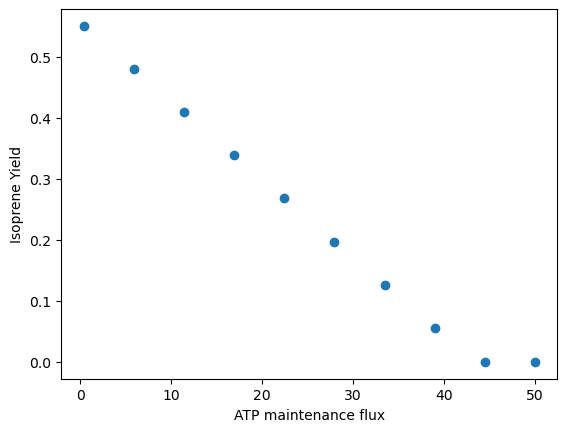

In [23]:
atpm = np.linspace(.4,50,10)
Substrate = 'meoh'
Product = 'isoprene[c]' #isoprene[c], succ[c]
Cnum = countCinFormula(model.metabolites.get_by_id(Product).formula)
IP_List = list()
flux=10
for atpmi in atpm:
    with model as md:
        md.reactions.get_by_id('ATPM').lower_bound = atpmi
        md = set_ObjGSMM(md, Product)
        md = set_SubFlux(md, [Substrate], 'Ex_glc_D', flux)
        sol = md.optimize()
        Yield = sol.fluxes['DM_{}'.format(Product)]*Cnum/flux
        IP_List.append([atpmi, Yield])
data = np.array(IP_List)
m,b = np.polyfit(data[:,0], data[:,1], 1)
print(m,b)
plt.scatter(data[:,0], data[:,1])
plt.xlabel('ATP maintenance flux')
plt.ylabel('Isoprene Yield')
plt.show()

findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Neue', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.


-3.448504683010354 0.5103211962074098


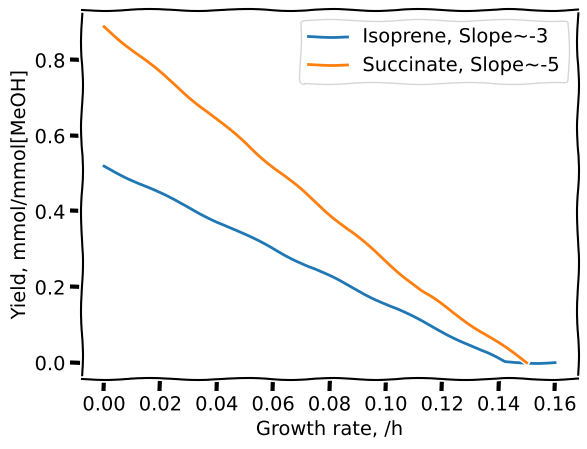

In [24]:
bio = np.linspace(.0,.15,5) # .0,.16,10
Substrate = 'meoh'
Product = 'succ[c]' #isoprene[c], 'succ[c]'
Cnum = countCinFormula(model.metabolites.get_by_id(Product).formula)
flux=10
Suc_List = list()
for bioi in bio:
    with model as md:
        md.reactions.get_by_id('BIOMASS').lower_bound = bioi
        md = set_ObjGSMM(md, Product)
        md = set_SubFlux(md, [Substrate], 'Ex_glc_D', flux)
        sol = md.optimize()
        Yield = sol.fluxes['DM_{}'.format(Product)]*Cnum/flux
        Suc_List.append([bioi, Yield])

bio = np.linspace(.0,.16,10)
Substrate = 'meoh'
Product = 'isoprene[c]' 
Cnum = countCinFormula(model.metabolites.get_by_id(Product).formula)
flux=10
IP_List = list()
for bioi in bio:
    with model as md:
        md.reactions.get_by_id('BIOMASS').lower_bound = bioi
        md.reactions.get_by_id('Ex_glc_D').lower_bound = 0
        md = set_ObjGSMM(md, Product)
        md = set_SubFlux(md, [Substrate], 'Ex_glc_D', flux)
        sol = md.optimize()
        Yield = sol.fluxes['DM_{}'.format(Product)]*Cnum/flux
        IP_List.append([bioi, Yield])
# visalization        
ipdata = np.array(IP_List)
sucdata = np.array(Suc_List)
m,n = np.polyfit(ipdata[:,0], ipdata[:,1], 1)
a,b = np.polyfit(sucdata[:,0], sucdata[:,1], 1)
print(m,n)
with plt.xkcd():
    plt.plot(ipdata[:,0], ipdata[:,1])
    plt.plot(sucdata[:,0], sucdata[:,1])
    plt.xlabel('Growth rate, /h')
    plt.ylabel('Yield, mmol/mmol[MeOH]')
    plt.legend([f'Isoprene, Slope~{int(m)}', f'Succinate, Slope~{int(a)}'])

# plt.savefig('Yields-VS-Growth_Isoprene+Suc_Opol.png')